<a href="https://colab.research.google.com/github/UmbertoFasci/SARIMA_SalesForecasting/blob/main/SARIMA_Retail_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting monthly sales using SARIMA model

## SARIMA Models Explained

SARIMA (Seasonal Autoregressive Integrated Moving Average) is built upon the ARIMA model architecture with the addition of a seasonal component. In order to dive into what SARIMA is and what it can do, let's first explore the base ARIMA model.

ARIMA (Autoregressive Integrated Moving Average), is a model which applies (1) autoregressive methodologies to (2) orders of differencing, while (3) maintaining a rolling average. It becomes clear when separated into three components.

### 1 Autoregressive Models

Autoregressive models are a class of machine learning models that automatically predict the next value in a sequence by looking back at measurements from previous inputs in the sequence. In a time-series context, Autoregression assumes that the current value of a time series is a function of its past values.

Other applications include the enablement of generative AI, where autoregressive modeling acts as an important component of large language models, image synthesis, data augmentation, and time-series prediction.

Autoregressive models are linear and the sum of squared errors (OLS) may be utilized as a loss function not unlike linear regression and gradient descent can be additionally leveraged to determine model parameters that minimize OLS.

\begin{equation}
X_t = c + φ_{t-1} X_{t-1} + φ_{t-2} X_{t-2} + \varepsilon_t
\end{equation}

### 2 Integrated Differencing

The second component of ARIMA models is made up of the orders of differencing which calculates the diference between the adjacent target values. One order of differencing is calculted by obtaining the difference between the direct adjacent target values, while two orders of differencing is calculated using the difference between the one order of differencing values.

The purpose for the integrated differencing component of ARIMA models is to increase this magnitude of order until stationarity is achieved. Stationarity is an assumption made of time-series when implementing a moving average.  

Refer to this [ARIMA Differencing Documentation](https://people.duke.edu/~rnau/411arim2.htm) for helpful instructions on identifying the appropriate order of differencing in an ARIMA model.

### 3 Moving-Average

The assumption behind moving-average models is that time-series fluctuate randomly around a mean, and the MA model attempts to capture the stochastic nature of the time series by modeling the target as a linear combination of the mean, the current error term, and previous error terms.By using lagged error terms, the predictions incorporate the information from past errors.

\begin{equation}
X_t = \mu + \varepsilon_t + θ_{t-1 \space \epsilon t-1} + \theta_{t-2 \space  ϵ t-2}
\end{equation}

The equation above is an example of a moving average model with two lagged error terms.


Wrapping up ARIMA modeling, the model assumes that a time-series can be modeled using (1) lagged target observations and (3) lagged error terms. As mentioned before, because ARIMA models assume a stationary time series, a certain number of orders of differencing must be used until stationarity is achieved (𝑑). In this way ARIMA models, and the three components can be summarized: (𝑝,𝑑,𝑞) where 𝑝 is the number of AR terms, 𝑑 is the orders of differencing, and 𝑞 is the number of lagged error terms.


---

## The Seasonal ARIMA (SARIMA)

In order to capture the seasonality component of a time-series, we utilize a SARIMA model which has seasonal ARIMA components (𝑃,𝐷,𝑄,𝑚) in addition to the normal ARIMA components (𝑝,𝑑,𝑞). 𝑚 represents the number of time periods in a season. If forecasting **monthly** sales then 𝑚 = 12, and 𝑃, 𝐷, 𝑄 are the same as 𝑝, 𝑑, 𝑞 except the former terms are using seasonal lags based on what 𝑚 is.

In this case, if 𝑃 = 2, then there are 2 seasonal autoregressive terms where the first term refers to the target observation 12 months ago and the second term refers to the target observation 24 months ago.

Overall, the components the make up a SARIMA model can be summarized: (𝑝,𝑑,𝑞)(𝑃,𝐷,𝑄,𝑚).

## Example Data Cleaning Procedure

The data for this example was gathered from the UCI Machine Learning Repository - Online Retail I data source. Since it only has 1 year of data, it will not do for any forecasting purposes. However, this dataset will only be utilized to display how I would approach data cleaning.

### Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
example_df = pd.read_csv('/content/drive/MyDrive/SARIMA_Forecasting/data/OnlineRetail.csv', parse_dates=['InvoiceDate'], infer_datetime_format=True)

/tmp/ipython-input-4122115828.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  example_df = pd.read_csv('/content/drive/MyDrive/SARIMA_Forecasting/data/OnlineRetail.csv', parse_dates=['InvoiceDate'], infer_datetime_format=True)


In [4]:
example_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
example_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
example_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [7]:
example_df.describe(include='object')

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


### Missing Value Handling

Having an initial look at the data, the most concerning missing value distribution is concentrated with the `CustomerID` feature which I expect to limit the analysis to the extent of its missingness.

Let's have a closer look at what the data looks like at these points of missingness.

In [8]:
example_df[example_df['CustomerID'].isna()].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom


Since there is no reasonable way to assume the identity of these customers, we can simply drop the missing `CustomerID` values. The missing `Description` values are not too important for the purposes of this procedure, but let's still take a look at how the data looks at those points as well.

In [9]:
example_df[example_df['Description'].isna()].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
1988,536550,85044,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
2025,536553,37461,NaN,3,2010-12-01 14:35:00,0.0,NaN,United Kingdom
2026,536554,84670,NaN,23,2010-12-01 14:35:00,0.0,NaN,United Kingdom
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom


Do all null `Descriptions` also have null `CustomerID`?

In [10]:
# True: `CustomerID` values exist on entries with missing `Description`
# False: All entries with null `Description` also have null `CustomerID`
description_null_customer_id = example_df[example_df['Description'].isna()]['CustomerID'].notna().any()

description_null_customer_id

np.False_

From that we can see that by handling the `CustomerID` column by dropping all missing values, the missing values in the `Description` feature will also be handled.

In the real-world, it is recommended to provide a missing value analysis - Asking why these values are missing and what that means for the original source data.

For example, for entry **622** where quantity = 56. This might be a bulk custom order for a specific distributor or partner store and the product is not publically available online, thus no real product was created for it. From my experience these usually represent ad-hoc product creations that are not completed through the product creation system, but through the product sales system instead.

In [11]:
example_df.dropna(subset=['CustomerID'], inplace=True)

### Negative Quantity Values

Earlier in the analysis, negative instances of `Quantity` can be noted. What that means will be explored in this section.

In [12]:
example_df[example_df['Quantity'] < 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


With the given data description which can be found [here](https://archive.ics.uci.edu/dataset/352/online+retail), a 'C' at the front of the of the invoice number represents orders which have been cancelled, and much of these negative quantities are cancelled orders. For the purposes of this procedure, negative quantity values representing canceled orders will be dropped from the dataset.

In [13]:
example_df = example_df[example_df['Quantity'] > 0]

On this note of Invoice Number codes, let's see if there are any additional ones besides 'C'. With a bit of regex magic we can remove all the numbers from the Invoice values and return only the letters. Since we dropped all negative quantities, we should expect for 'C' to be absent from this list.

In [14]:
example_df['InvoiceNo'].str.replace("[0-9]", "", regex=True).unique()

array([''], dtype=object)

'C' is absent, and there are no additional invoice descriptors besides those that described the already removed cancelled orders.

### Stock Code Assertion

This feature is described as a 5-digit inegral number uniquely assigned to each distinct product. Let's assert that this is the case for every stock code that appears in the remaining dataset.

In [15]:
example_df['StockCode'] = example_df['StockCode'].astype(str)
example_df[example_df['StockCode'].str.match("\\d{5}$") == False]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2011-12-09 12:16:00,4.15,12713.0,Germany
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2011-12-09 12:19:00,1.79,17581.0,United Kingdom
541838,581580,84993A,75 GREEN PETIT FOUR CASES,2,2011-12-09 12:20:00,0.42,12748.0,United Kingdom
541844,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2011-12-09 12:20:00,1.25,12748.0,United Kingdom


As can be noted with the above return, there are **34,805** entries with stock codes that do not match the provided discription. Thus, further investigation on why this is must be completed.

Top level looks of this suggest that most of what is shown represents legitmate product codes, except for `POST`. Let's see if there are any other stock codes that are not just the usual 5 digit integral with an appended character.

In [16]:
example_df[(example_df["StockCode"].str.match("^\\d{5}$") == False) & (example_df["StockCode"].str.match("^\\d{5}[a-zA-z]+$") == False)]["StockCode"].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

- `POST`: seems to be a non-consumer transaction which might represent shipping costs.
- `C2`: with the `CARRIAGE` descriptor seems to represent another shipping non-consumer transaction.
- `M`: unknown product type, inconsistent unit pricing.
- `BANK CHARGES`: non-consumer, representing bank fees.
- `PADS`: seems to be a consumer transaction, very neglegible.
- `DOT`: more non-consumer shipping fees.

For the purposes of this procedure I will be dropping all non-consumer product transactions.

In [17]:
example_df["StockCode"] = example_df["StockCode"].astype("str")

mask = (
    (example_df["StockCode"].str.match("^\\d{5}&") == True)
    | (example_df["StockCode"].str.match("^\\d{5}[a-zA-z]+$") == True)
    | (example_df["StockCode"].str.match("^PADS") == True)
)

example_df = example_df[mask]

It seems that there are some `UnitPrices` that include 0 and below; for the sake of this example I will be dropping all of these occurences to only include prices above zero: prices that reflect an item sold.

In [18]:
example_df = example_df[example_df['UnitPrice'] > 0]

In [19]:
example_df['Revenue'] = example_df['Quantity'] * example_df['UnitPrice']

print(f"Total revenue: ${example_df['Revenue'].sum():,.2f}")

# monthly sales aggregation
example_df['YearMonth'] = example_df['InvoiceDate'].dt.to_period('M')
example_monthly_sales = example_df.groupby('YearMonth')['Revenue'].sum().reset_index()
example_monthly_sales['YearMonth'] = example_monthly_sales['YearMonth'].dt.to_timestamp()

example_monthly_sales.describe()



Total revenue: $745,717.11


,YearMonth,Revenue
count,13,13.000000
mean,2011-06-01 07:23:04.615384576,57362.854846
min,2010-12-01 00:00:00,19178.900000
25%,2011-03-01 00:00:00,51021.310000
50%,2011-06-01 00:00:00,60745.240000
75%,2011-09-01 00:00:00,63181.320000
max,2011-12-01 00:00:00,84511.520000
std,NaN,14824.570826


Looking at the data and the resulting monthly revenue over time, the maximum recorded date being the first day of December 2011 creates an artifact of extreme revenue drop, which is especially apparant when plotted out.

Knowing this, it is a good idea to limit the range to exclude this single day of revenue data for the sake of

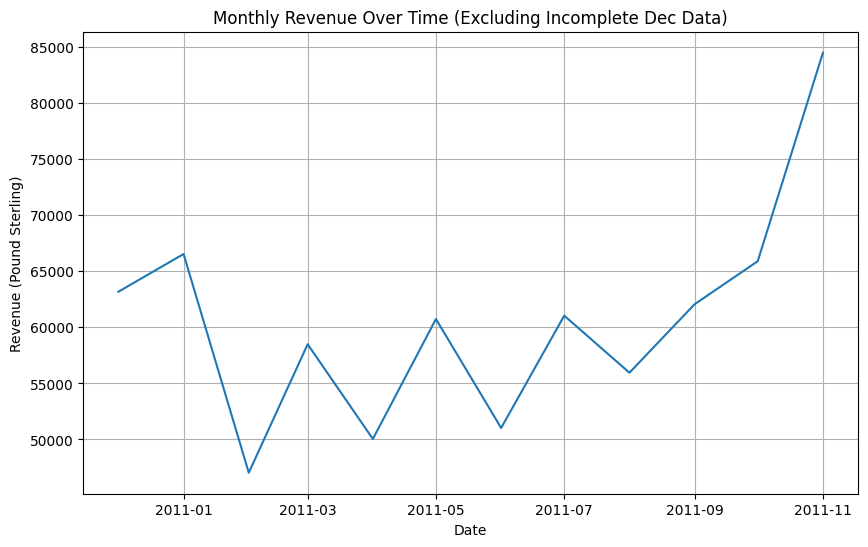

In [20]:
example_monthly_sales_filtered = example_monthly_sales[example_monthly_sales['YearMonth'] != example_monthly_sales['YearMonth'].max()]

plt.figure(figsize=(10, 6))
sns.lineplot(data=example_monthly_sales_filtered, x='YearMonth', y='Revenue')
plt.title('Monthly Revenue Over Time (Excluding Incomplete Dec Data)')
plt.xlabel('Date')
plt.ylabel('Revenue (Pound Sterling)')
plt.grid(True)
plt.show()

To reiterate, the data that was just cleaned and briefly explored was introduced for the purpose of showcasing how I would approach such a procedure. Considering that there is only one year of available data, it is not an appropriate input to train a forecasting model. For this reason, a dataset with admitibly less cleaning necessities will be leveraged to demonstrate the power of SARIMA forecasting.

With this data, appropriate analysis will be done in order to address the conditions required when developing a forecasting model with SARIMA.

In [25]:
sales_df = pd.read_csv('/content/drive/MyDrive/SARIMA_Forecasting/data/Superstore.csv', parse_dates=['Order Date', 'Ship Date'], infer_datetime_format=True)

/tmp/ipython-input-990482249.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  sales_df = pd.read_csv('/content/drive/MyDrive/SARIMA_Forecasting/data/Superstore.csv', parse_dates=['Order Date', 'Ship Date'], infer_datetime_format=True)


In [26]:
sales_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [27]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

An initial look at the data shows that there are no null values in the collection. Hance, there is no missing data handling necessary.

In [30]:
sales_df.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2016-04-30 00:07:12.259355648,2016-05-03 23:06:58.571142912,55190.379428,229.858001,3.789574,0.156203,28.656896
min,1.000000,2014-01-03 00:00:00,2014-01-07 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2015-05-23 00:00:00,2015-05-27 00:00:00,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2016-06-26 00:00:00,2016-06-29 00:00:00,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2017-05-14 00:00:00,2017-05-18 00:00:00,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000
std,2885.163629,NaN,NaN,32063.693350,623.245101,2.225110,0.206452,234.260108


In [31]:
sales_df.describe(include='object')

,Order ID,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994
unique,5009,4,793,793,3,1,531,49,4,1862,3,17,1850
top,CA-2017-100111,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,14,5968,37,37,5191,9994,915,2001,3203,19,6026,1523,48


There are no obvious value ranges that need to be addressed in the same way as the previous dataset.

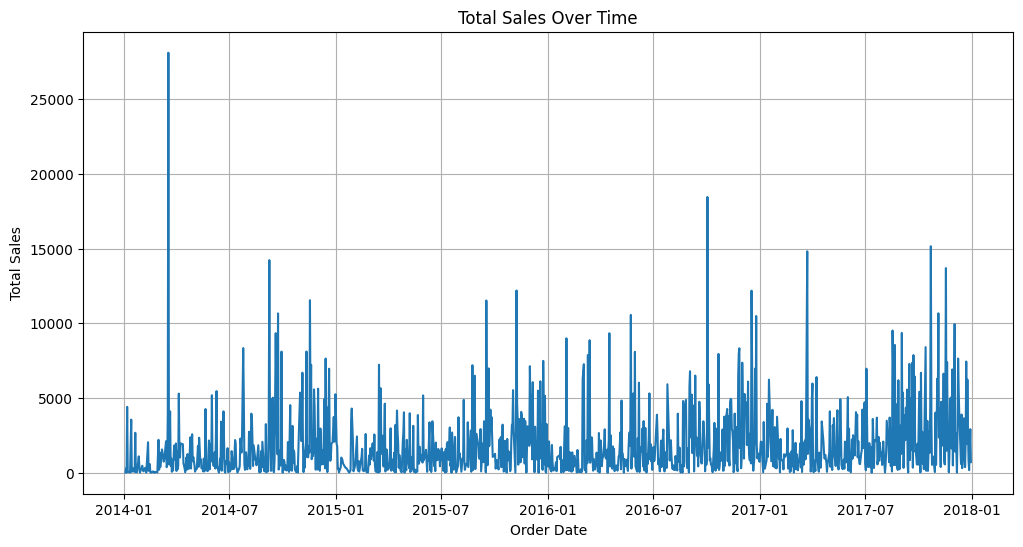

In [29]:
sales_by_date = sales_df.groupby('Order Date')['Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_by_date, x='Order Date', y='Sales')
plt.title('Total Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [33]:
monthly_sales_df = sales_df.resample('M', on='Order Date')['Sales'].sum().reset_index()
monthly_sales_df.head(10)

/tmp/ipython-input-4045816224.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales_df = sales_df.resample('M', on='Order Date')['Sales'].sum().reset_index()


,Order Date,Sales
0,2014-01-31,14236.8950
1,2014-02-28,4519.8920
2,2014-03-31,55691.0090
3,2014-04-30,28295.3450
4,2014-05-31,23648.2870
5,2014-06-30,34595.1276
6,2014-07-31,33946.3930
7,2014-08-31,27909.4685
8,2014-09-30,81777.3508
9,2014-10-31,31453.3930


In [34]:
monthly_sales_df.describe()

,Order Date,Sales
count,48,48.000000
mean,2016-01-14 21:30:00,47858.351256
min,2014-01-31 00:00:00,4519.892000
25%,2015-01-23 06:00:00,29790.096125
50%,2016-01-15 12:00:00,39803.248500
75%,2017-01-07 18:00:00,65833.343625
max,2017-12-31 00:00:00,118447.825000
std,NaN,25195.890700


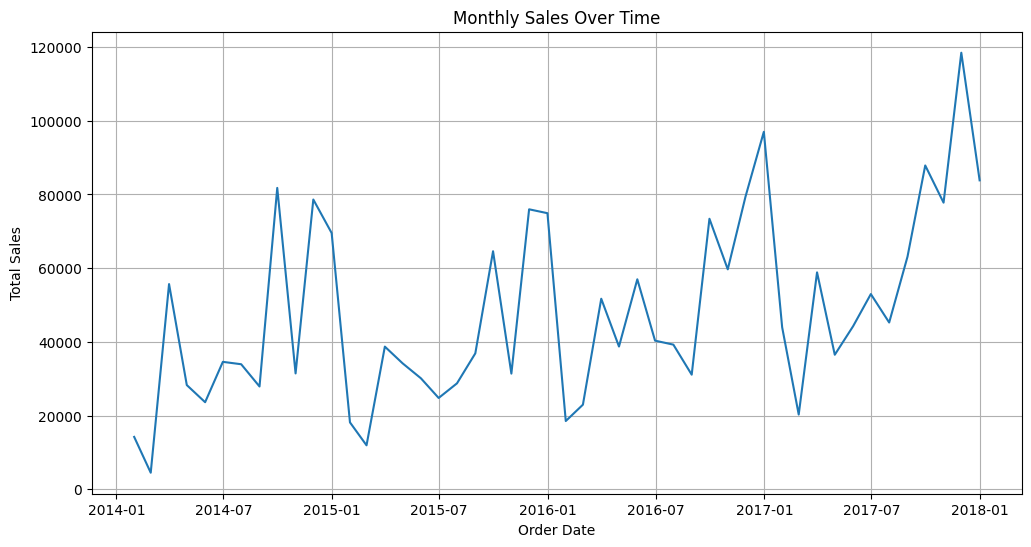

In [35]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales_df, x='Order Date', y='Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()